# SSL and CNN

In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load CSV file
file_path = r"MATWI/labels.csv"
df = pd.read_csv(file_path)

# Drop rows where 'type' or 'ImageFile' is NaN or empty
df = df.dropna(subset=['type', 'ImageFile'])
df = df[df['type'].str.strip() != '']  # Ensure no empty labels in 'type'



In [2]:
def load_and_resize_image(image_path, size=(224, 224)):
    img = cv2.imread(image_path)  # Load image in BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, size)  # Resize to target dimensions
    return img

# Load and preprocess images
df['Images'] = df['ImageFile'].apply(lambda x: load_and_resize_image(x))
images = np.stack(df['Images'].values) / 255.0  # Normalize to [0, 1]
df['type'].value_counts()

type
flank_wear             1154
flank_wear+adhesion     335
adhesion                179
Name: count, dtype: int64

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
# Perform stratified train-test split
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['type']
)


val_df, tst_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['type'])
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Random horizontal and vertical flips
    layers.RandomRotation(0.2),  # Random rotation by up to 20%
    layers.RandomZoom(0.2),  # Random zoom
    layers.RandomContrast(0.1)  # Random contrast adjustment
])
# Function to apply data augmentation on a set of images
def augment_images(images, num_augmented=6):
    augmented_images = []
    for img in images:
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)  # Ensure image dtype is float32
        augmented_images.append(img)
        for _ in range(num_augmented - 1):
            augmented_img = data_augmentation(tf.expand_dims(img, axis=0))  # Apply augmentation
            augmented_images.append(augmented_img[0].numpy())  # Remove batch dimension and add to list
    return np.array(augmented_images)


In [16]:
import numpy as np

# Separate the data for the three labels: adhesion, flank_wear, and flank_wear+adhesion
adhesion_images = train_df[train_df['type'] == 'adhesion']['Images'].tolist()
flank_wear_images = train_df[train_df['type'] == 'flank_wear']['Images'].tolist()
flank_wear_adhesion_images = train_df[train_df['type'] == 'flank_wear+adhesion']['Images'].tolist()

# Augment only 'adhesion' and 'flank_wear+adhesion' images
adhesion_augmented = augment_images(np.array(adhesion_images), num_augmented=7)  # Augment by a factor of 10
flank_wear_adhesion_augmented = augment_images(np.array(flank_wear_adhesion_images), num_augmented=6)  # Augment by a factor of 7

# No augmentation for 'flank_wear' images
flank_wear_augmented = np.array(flank_wear_images)

# Combine all the augmented data and the original unaugmented data
X_train_augmented = np.concatenate([adhesion_augmented, flank_wear_adhesion_augmented, flank_wear_augmented])

# One-hot encode the corresponding labels for training
adhesion_labels = np.array([[1, 0, 0]] * len(adhesion_augmented))  # [1, 0, 0] for 'adhesion'
flank_wear_labels = np.array([[0, 1, 0]] * len(flank_wear_augmented))  # [0, 1, 0] for 'flank_wear'
flank_wear_adhesion_labels = np.array([[0, 0, 1]] * len(flank_wear_adhesion_augmented))  # [0, 0, 1] for 'flank_wear+adhesion'

y_train_augmented = np.concatenate([adhesion_labels, flank_wear_adhesion_labels, flank_wear_labels])

# Perform augmentation on validation set as well
adhesion_val_images = val_df[val_df['type'] == 'adhesion']['Images'].tolist()
flank_wear_adhesion_val_images = val_df[val_df['type'] == 'flank_wear+adhesion']['Images'].tolist()

# Augment only 'adhesion' and 'flank_wear+adhesion' validation images
adhesion_val_augmented = augment_images(np.array(adhesion_val_images), num_augmented=7)
flank_wear_adhesion_val_augmented = augment_images(np.array(flank_wear_adhesion_val_images), num_augmented=6)

# No augmentation for 'flank_wear' validation images
flank_wear_val_images = val_df[val_df['type'] == 'flank_wear']['Images'].tolist()
flank_wear_val_augmented = np.array(flank_wear_val_images)

# Combine the augmented validation data
X_val_augmented = np.concatenate([adhesion_val_augmented, flank_wear_adhesion_val_augmented, flank_wear_val_augmented])

# One-hot encode the corresponding labels for validation
adhesion_val_labels = np.array([[1, 0, 0]] * len(adhesion_val_augmented))  # [1, 0, 0] for 'adhesion'
flank_wear_adhesion_val_labels = np.array([[0, 0, 1]] * len(flank_wear_adhesion_val_augmented))  # [0, 0, 1] for 'flank_wear+adhesion'
flank_wear_val_labels = np.array([[0, 1, 0]] * len(flank_wear_val_augmented))  # [0, 1, 0] for 'flank_wear'

y_val_augmented = np.concatenate([adhesion_val_labels, flank_wear_adhesion_val_labels, flank_wear_val_labels])

# Count the classes in the augmented data
train_class_counts = np.sum(y_train_augmented, axis=0)
val_class_counts = np.sum(y_val_augmented, axis=0)

# Print the class counts for training and validation sets
class_names = ['adhesion', 'flank_wear', 'flank_wear+adhesion']

print("Class counts in training set:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {train_class_counts[i]}")

print("\nClass counts in validation set:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {val_class_counts[i]}")


Class counts in training set:
adhesion: 875
flank_wear: 808
flank_wear+adhesion: 1404

Class counts in validation set:
adhesion: 189
flank_wear: 173
flank_wear+adhesion: 300


In [18]:
from tensorflow.keras.utils import to_categorical
def create_rotation_dataset(images):
    augmented_images = []
    pseudo_labels = []
    angles = [0, 90, 180, 270]
    
    for img in images:
        for angle in angles:
            if angle == 0:
                rotated = img
            else:
                rotated = np.rot90(img, k=angle // 90)  # Rotate image
            augmented_images.append(rotated)
            pseudo_labels.append(angles.index(angle))
    
    return np.array(augmented_images), np.array(pseudo_labels)

ssl_images, ssl_labels = create_rotation_dataset(X_train_augmented)
ssl_labels_onehot = to_categorical(ssl_labels, num_classes=4)


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_ssl_model(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, input_shape=input_shape, pooling='avg'
    )
    x = layers.Dense(128, activation='relu')(base_model.output)
    output = layers.Dense(4, activation='softmax')(x)  # 4 rotation classes
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model

ssl_model = build_ssl_model()
ssl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
ssl_model.fit(ssl_images, ssl_labels_onehot, epochs=1, batch_size=32)


386/386 ━━━━━━━━━━━━━━━━━━━━ 2353s 6s/step - accuracy: 0.4033 - loss: 1.1932


In [26]:
def build_classification_model(pretrained_model, num_classes):
    x = layers.Dense(128, activation='relu')(pretrained_model.layers[-2].output)
    output = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=output)
    return model

#num_classes = len(df['type_encoded'].unique())
classification_model = build_classification_model(ssl_model, 3)
classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
                             loss='categorical_crossentropy', 
                             metrics=['accuracy'])


In [28]:
classification_model.fit(X_train_augmented, y_train_augmented, epochs=1, batch_size=32, validation_split=0.2)


78/78 ━━━━━━━━━━━━━━━━━━━━ 2704s 35s/step - accuracy: 0.4862 - loss: 1.0553 - val_accuracy: 1.0000 - val_loss: 0.3978


In [24]:
test_loss, test_accuracy = classification_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6902 - loss: 1.0699
Test Accuracy: 69.16%


In [40]:
# Generate predicted probabilities
y_pred_probabilities = classification_model.predict(X_test)

# Convert probabilities to predicted class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


In [46]:
import numpy as np

# Define your one-hot encoded vectors
vector_1 = np.array([1, 0, 0])
vector_2 = np.array([0, 1, 0])
vector_3 = np.array([0, 0, 1])

# Count occurrences of each vector
count_1 = np.sum(np.all(y_train_augmented == vector_1, axis=1))
count_2 = np.sum(np.all(y_train_augmented == vector_2, axis=1))
count_3 = np.sum(np.all(y_train_augmented == vector_3, axis=1))

print(f"Flank: {count_1}")
print(f"Adhesive: {count_2}")
print(f"Flank+adhesive: {count_3}")


(1, 0, 0): 286
(0, 1, 0): 1846
(0, 0, 1): 536


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6902 - loss: 1.0699
Test Accuracy: 69.16%
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


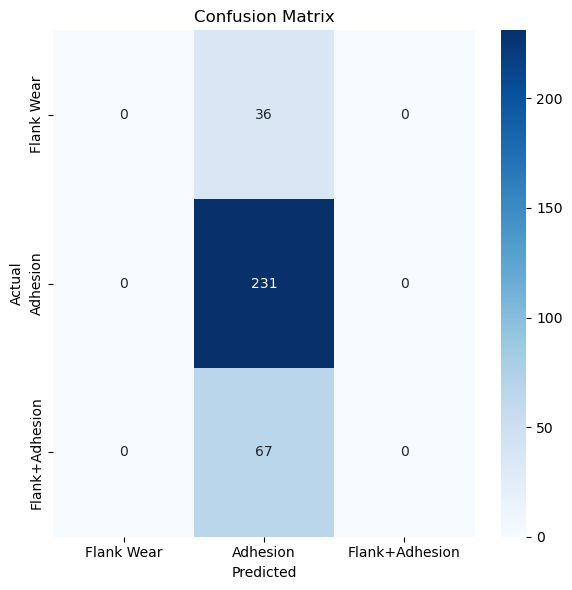

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = classification_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict the test set labels
y_pred = classification_model.predict(X_test)

# Convert predictions to class labels by taking the argmax (for multi-class classification)
y_pred_labels = np.argmax(y_pred, axis=1)

# Flatten the true labels to match the predicted labels shape
y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flank Wear', 'Adhesion', "Flank+Adhesion"], yticklabels=['Flank Wear', 'Adhesion', "Flank+Adhesion"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



In [34]:
y_pred

array([[0.32311532, 0.35180044, 0.32508418],
       [0.3231289 , 0.35178018, 0.3250909 ],
       [0.32310686, 0.35181308, 0.32508004],
       ...,
       [0.32313332, 0.35177368, 0.32509303],
       [0.323156  , 0.35173982, 0.32510415],
       [0.32309142, 0.3518374 , 0.32507116]], dtype=float32)

In [44]:
y_pred_probabilities

array([[0.32311532, 0.35180044, 0.32508418],
       [0.3231289 , 0.35178018, 0.3250909 ],
       [0.32310686, 0.35181308, 0.32508004],
       ...,
       [0.32313332, 0.35177368, 0.32509303],
       [0.323156  , 0.35173982, 0.32510415],
       [0.32309142, 0.3518374 , 0.32507116]], dtype=float32)

In [46]:
y_true_labels

array([1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2,
       1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1,
       1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,